# SSVGP demo on a toy example

### $Y = \sum_{i=1}^{10} \sin(a_iX_i) + \epsilon_i, \epsilon_i \sim N(0,\sigma^2)$

In [1]:
"""
Importing general library requirements
"""
user = "nk1922"

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import time # just for measuring runtime

""" 
SS GP algorithm functions
"""
import os
os.chdir('C:/Users/{0}/Downloads'.format(user))
from SSVGP import kernel_funcs
from SSVGP import model_funcs
from SSVGP import draw_simulation
from SSVGP import train
from SSVGP import evaluation
from SSVGP import test
from SSVGP import diagnostics
from functools import partial

In [8]:
"""
# Draw dataset from toy example
"""
# Dataset example
n=1000
ntrain=n
ntest=1000
p=100 # input dims (p-q are irrelevant)
q=5
# Drawing and scaling data
np.random.seed(1)
Y,X,f = draw_simulation.toy_example(n+ntest,q=q,p=100)
Xtrain = (X[:n]-X[:n].mean(0))/X[:n].var(0)**0.5
Xtest = (X[n:]-X[:n].mean(0))/X[:n].var(0)**0.5
ytrain = (Y[:n]-Y[:n].mean())/Y[:n].var()**0.5
ytest = (Y[n:]-Y[:n].mean())/Y[:n].var()**0.5
MSE = np.zeros(1)
runtime = np.zeros(1)

In [9]:
# Training
t = time.time()
np.random.seed(0)
linit,sinit,siginit,logl,L,opt_sums = train.kernel_param_optimise(ytrain.reshape(ntrain,1),Xtrain)
Results,Selections = train.model(ytrain,Xtrain, 
                                 training_args = ["l0", "s0", "sig0", "init_grad_step", "optimisation_sums"], 
                                 training_arg_vals = [linit,sinit,siginit, 0, opt_sums])
print("Finished training, starting model evaluation")

# Evaluation (LOO-LPD computation)
loo_lpd,pip,mu,weights = evaluation.model(ytrain,Xtrain,Results)
print("Finished evaluation, starting testing")
# Testing
testing_algorithm = partial(test.posterior_predictive)
fmean,ymean = test.model(ytrain,Xtrain,Xtest,testing_algorithm,Results,weights)

runtime[0] = time.time()-t
MSE[0] =  diagnostics.MSE_pc(ymean.reshape(ntest,1),ytest.reshape(ntest,1))
print("MSE is : ", MSE[0])
print("Runtime is : ", runtime[0])

Finished training, starting model evaluation
LOO-LPD 1 is : -88.20702854226472
LOO-LPD 2 is : -89.55575127638454
LOO-LPD 3 is : -86.9872090552509
LOO-LPD 4 is : -84.9859292693967
LOO-LPD 5 is : -84.11456183248461
LOO-LPD 6 is : -87.07102769498884
LOO-LPD 7 is : -86.57103539747756
LOO-LPD 8 is : -290.384486395389
LOO-LPD 9 is : -501.2447271901441
LOO-LPD 10 is : -1501.2447271901442
LOO-LPD 11 is : -2501.244727190144
Finished evaluation, starting testing
MSE is :  0.06385135638674881
Runtime is :  68.0352156162262


## SSVGP results

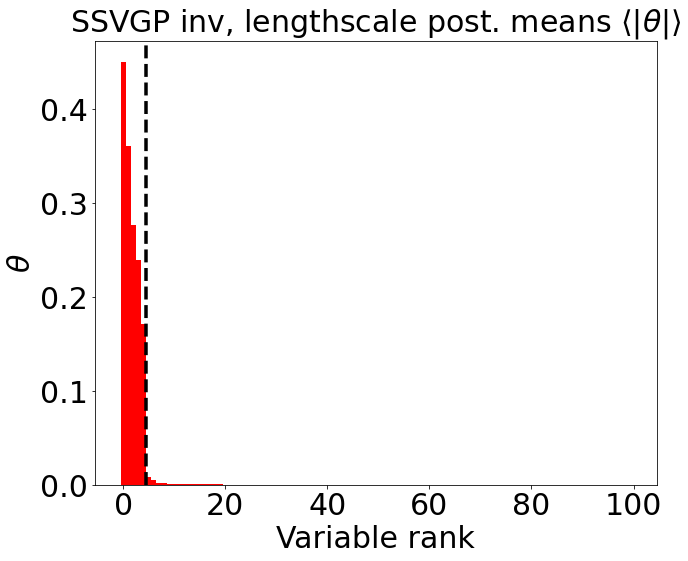

In [12]:
"""
Plotting inverse lengthscale post.means ordered by size
"""
plt.rc('axes',edgecolor='black')
font ={'size'   : 30}
plt.rc('font', **font)
d=100 
sorted_ILS = np.concatenate((np.sort(mu[:q])[::-1],np.sort(mu[q:])[::-1]))

plt.rcParams.update({'text.color' : "black",
                      'xtick.color' : "black",
                      'ytick.color' : "black",
                     'axes.labelcolor' : "black"})
fig,axs = plt.subplots(figsize=(10,8.5))
fig.set_facecolor('white')
axs.set_facecolor('white')
axs.set_xlabel("Variable rank")
axs.set_ylabel(r"$\theta$")
axs.set_title(r"SSVGP inv, lengthscale post. means $\langle| \theta |\rangle $",fontsize=30)
plt.bar(range(d),height = sorted_ILS[:d], width = 0.65+(p>10)*0.35, color = "red")
plt.axvline(x=q-0.5, color = "black", linestyle = "--", lw = 3.5)
plt.tight_layout()

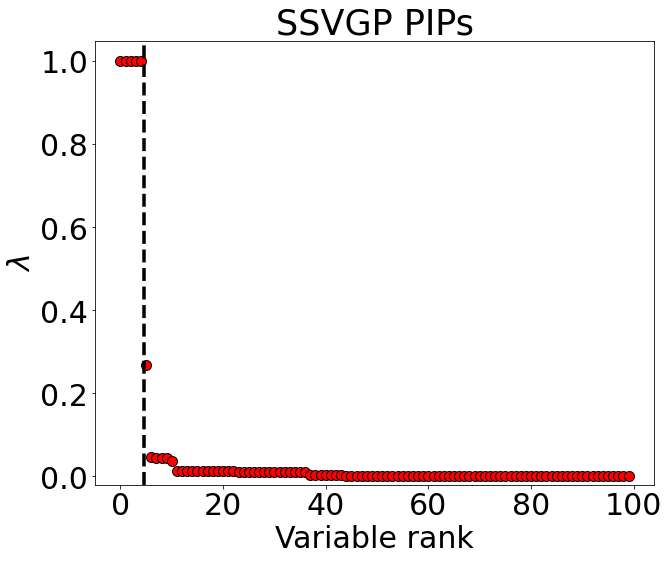

In [13]:
"""
Plotting PIPs ordered by size
"""
plt.rc('axes',edgecolor='black')
font ={'size'   : 30}
plt.rc('font', **font)

sorted_PIPs = np.concatenate((np.sort(pip[:q])[::-1],np.sort(pip[q:])[::-1]))

fig,axs = plt.subplots(figsize=(10,8.5))
plt.xlabel("Variable rank")
plt.ylabel(r"$\lambda$")
axs.set_title(r"SSVGP PIPs", fontsize=35)

plt.scatter(range(d),sorted_PIPs[:d], color = "red", s=100, marker = "o", edgecolors="black")
plt.ylim(-0.02,1.05)
plt.axvline(x=q-0.5, linestyle = "--", color = "black", label = "LHS: true inclusions"+"\n"+"RHS: true exclusions", lw = 3.5)
plt.tight_layout()
plt.show()